In [2]:
from google.colab import files
uploaded = files.upload()


Saving speaker1.mp3 to speaker1.mp3
Saving speaker2.mp3 to speaker2.mp3


In [3]:
!pip install pydub

In [0]:
import subprocess
from pydub import AudioSegment
from wave import open as open_wave
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import librosa
import glob
import math
import random

In [0]:
!mkdir wavspeaker

In [15]:
for i in range(0,2):
subprocess.call(['ffmpeg', '-i', './speaker{}.mp3'.format(i+1),
                   './wavspeaker/speaker{}.wav'.format(i+1)])

0

In [0]:
total_length = 300000
segment_length = 3000
segments = total_length/segment_length
segments = int(segments)

In [0]:
for i in range(0,2):
    t1 = 0
    newAudio = AudioSegment.from_wav('./wavspeaker/speaker{}.wav'.format(i+1))
    for j in range(0,segments): 
        newAudio1 = newAudio[t1:(t1+segment_length)]
        newAudio1.export('./dataset/s{}/{}.wav'.format(i, j), format="wav")
        t1 = t1 + segment_length

In [0]:
def data_make(file_path):
    dataset = glob.glob(file_path)
    data1 = []
    for i in range(0,segments):
        y, sr = librosa.load(dataset[i], sr=1200)
        y=np.reshape(y, (-1, int(math.sqrt(y.size))))
        data1.append(y)
    return data1

In [ ]:
data1 = data_make('./dataset/s1/*.wav')
data2 = data_make('./dataset/s2/*.wav')

In [0]:
data1 = np.array(data1)
data2 = np.array(data2)

In [0]:
data1 = np.expand_dims(data1, axis=3)
data2 = np.expand_dims(data2, axis=3)

In [29]:
data1.shape

(100, 60, 60, 1)

In [88]:
data1[0].shape

(60, 60, 1)

In [0]:
def pair_make(item, datacat1, datacat2):
    pair = []
    pair1 = []
    for i in range(item):
        indx = np.random.randint(0, 100)
        indx1 = np.random.randint(0, 100)
        pair.append(datacat1[indx])
        pair1.append(datacat2[indx1])
    return pair, pair1

In [ ]:
pair1, pair11 = pair_make(50, data1,data1)
pair2,  pair21 = pair_make(50, data2,data2)
pair1 = pair1 + pair2
pair11 = pair11 + pair21
pair0, pair01 = pair_make(100, data1,data2)

In [0]:
label1 = [1]*100
label0 = [0]*100

In [153]:
lside[100]

array([[[-0.01937202],
        [-0.00162905],
        [ 0.01080856],
        ...,
        [ 0.00303439],
        [-0.00319143],
        [-0.00324043]],

       [[ 0.00322244],
        [ 0.0035693 ],
        [-0.00386932],
        ...,
        [ 0.00024548],
        [-0.00043418],
        [ 0.00404044]],

       [[-0.01081412],
        [ 0.00463388],
        [ 0.0027859 ],
        ...,
        [-0.00217403],
        [ 0.00284905],
        [-0.00108507]],

       ...,

       [[ 0.00400005],
        [ 0.00132786],
        [-0.00399965],
        ...,
        [-0.00117449],
        [ 0.00264769],
        [ 0.00790705]],

       [[-0.0077268 ],
        [-0.0046042 ],
        [ 0.00602949],
        ...,
        [ 0.00053113],
        [ 0.00030939],
        [-0.00062905]],

       [[-0.00035683],
        [ 0.00060006],
        [ 0.00081326],
        ...,
        [ 0.00392649],
        [-0.00768042],
        [-0.00362523]]], dtype=float32)

In [0]:
lside = pair1 + pair0
rside = pair11 + pair01
labels = label1 + label0

In [0]:
labels = np.array(labels)

In [0]:
X_l = np.array(lside)
X_r = np.array(rside)

In [155]:
X_r.shape

(200, 60, 60, 1)

In [0]:
from keras.models import Sequential
import time
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model
import seaborn as sns
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras import backend as K

In [0]:
def get_siamese_model(input_shape):
    
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    model = Sequential()
    BATCH_NORM = 1
    model.add(Conv2D(8, (3, 3), padding='same', input_shape=(60,60,1), name='block1_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(8, (3, 3), padding='same', name='block1_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

    model.add(Conv2D(64, (3, 3), padding='same', name='block2_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3), padding='same', name='block2_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

    model.add(Conv2D(128, (3, 3), padding='same', name='block3_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3), padding='same', name='block3_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3), padding='same', name='block3_conv3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3), padding='same', name='block3_conv4'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block4_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block4_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block4_conv3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block4_conv4'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block5_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block5_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block5_conv3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block5_conv4'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Flatten())

    model.add(Dense(2048))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(2048, name='fc2'))
    
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    return siamese_net

In [134]:
model = get_siamese_model((60,60,1))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 60, 60, 1)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 60, 60, 1)    0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 2048)         13920600    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 2048)         0           sequential_2[1][0]               
          

In [0]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy'])

In [156]:

# Train the discriminator
d_loss = model.fit([X_l, X_r],labels,validation_split=0.33,nb_epoch=100,verbose=1,shuffle=True)

print( d_loss)

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 134 samples, validate on 66 samples
Epoch 1/100
134/134 [==============================] - 14s 102ms/step - loss: 1.0651 - acc: 0.3433 - val_loss: 0.9334 - val_acc: 0.5758
Epoch 2/100
134/134 [==============================] - 1s 6ms/step - loss: 0.6650 - acc: 0.6045 - val_loss: 0.8097 - val_acc: 0.5455
Epoch 3/100
134/134 [==============================] - 1s 6ms/step - loss: 0.5320 - acc: 0.7090 - val_loss: 0.6784 - val_acc: 0.7273
Epoch 4/100
134/134 [==============================] - 1s 6ms/step - loss: 0.4927 - acc: 0.8284 - val_loss: 0.3292 - val_acc: 0.9091
Epoch 5/100
134/134 [==============================] - 1s 6ms/step - loss: 0.4394 - acc: 0.7836 - val_loss: 0.0961 - val_acc: 0.9848
Epoch 6/100
134/134 [==============================] - 1s 6ms/step - loss: 0.3725 - acc: 0.8731 - val_loss: 0.0317 - val_acc: 1.0000
Epoch 7/100
134/134 [==============================] - 1s 6ms/step - loss: 0.3292 - acc: 0.8955 - val_loss: 0.0347 - val_acc: 1.0000
Epoch 8/100
134/134 [

In [0]:
import matplotlib.pyplot as plt

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


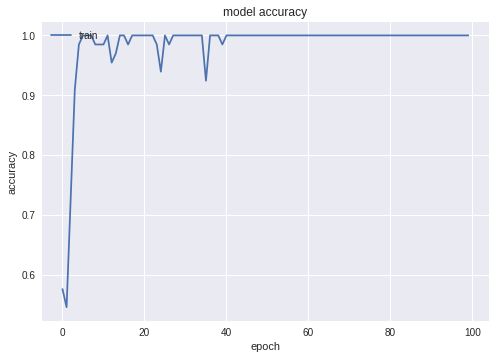

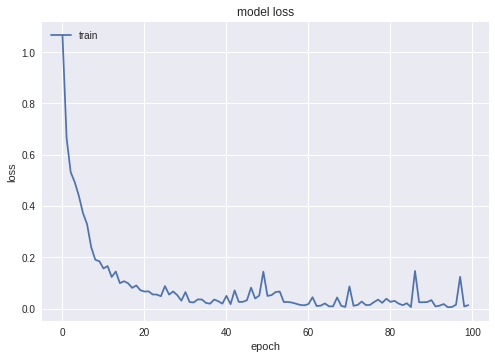

In [158]:
print(d_loss.history.keys())
# summarize history for accuracy
#plt.plot(d_loss.history['acc'])
plt.plot(d_loss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(d_loss.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
